# OverNaN Example: Comparing Missing Value Strategies for Imbalanced Classification

This notebook demonstrates the advantages of using OverNaN for oversampling imbalanced datasets with missing values.

We compare four approaches:
1. **Drop Features**: Remove features containing NaN values, then apply standard SMOTE
2. **Drop Instances**: Remove samples containing NaN values, then apply standard SMOTE
3. **Imputation**: Fill NaN values using mean imputation, then apply standard SMOTE
4. **SMOTENaN**: Use OverNaN's native NaN-aware SMOTE implementation

We evaluate each approach using XGBoost (which handles NaN natively) on a synthetic dataset with controlled missingness.

In [2]:
# =============================================================================
# Imports and Configuration
# =============================================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score
)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import warnings
import gc

# Import OverNaN
from overnan import SMOTENaN

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set global random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("Imports complete.")

Imports complete.


In [3]:
# =============================================================================
# Generate Synthetic Dataset with Missing Values
# =============================================================================

def generate_imbalanced_data_with_nan(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    imbalance_ratio=0.2,
    n_features_with_nan=12,
    nan_rate_in_affected=0.2,
    random_state=42
):
    """
    Generate a synthetic imbalanced classification dataset with missing values.
    
    NaN values are concentrated in a subset of features (realistic scenario
    where some variables have missingness but others are complete).
    
    Parameters
    ----------
    n_samples : int
        Total number of samples.
    n_features : int
        Total number of features.
    n_informative : int
        Number of informative features.
    imbalance_ratio : float
        Ratio of minority to majority class (e.g., 0.1 means 10:1 imbalance).
    n_features_with_nan : int
        Number of features that will contain NaN values.
    nan_rate_in_affected : float
        Fraction of values to set as NaN within affected features.
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    X : np.ndarray
        Feature matrix with NaN values.
    y : np.ndarray
        Binary target labels.
    """
    # Set random state
    rng = np.random.RandomState(random_state)
    
    # Calculate class weights for imbalanced data
    weight_minority = imbalance_ratio / (1 + imbalance_ratio)
    weight_majority = 1 / (1 + imbalance_ratio)
    
    # Generate base dataset
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=2,
        n_clusters_per_class=2,
        weights=[weight_majority, weight_minority],
        flip_y=0.1,
        random_state=random_state
    )
    
    # Select which features will have NaN (concentrated missingness)
    features_with_nan_idx = rng.choice(n_features, size=n_features_with_nan, replace=False)
    
    # Introduce NaN only in selected features
    for feat_idx in features_with_nan_idx:
        nan_mask = rng.random(n_samples) < nan_rate_in_affected
        X[nan_mask, feat_idx] = np.nan
    
    return X, y


# Generate the dataset
# 10 of 20 features have NaN, with 25% missingness in those features
X, y = generate_imbalanced_data_with_nan(
    n_samples=2000,
    n_features=20,
    n_informative=12,
    imbalance_ratio=0.2,
    n_features_with_nan=12,
    nan_rate_in_affected=0.2,
    random_state=RANDOM_STATE
)

# Report dataset statistics
n_minority = np.sum(y == 1)
n_majority = np.sum(y == 0)
nan_percentage = np.isnan(X).sum() / X.size * 100
features_with_nan = np.sum(np.any(np.isnan(X), axis=0))
features_without_nan = np.sum(~np.any(np.isnan(X), axis=0))
instances_with_nan = np.sum(np.any(np.isnan(X), axis=1))
instances_without_nan = np.sum(~np.any(np.isnan(X), axis=1))

print("Dataset Statistics")
print("=" * 40)
print(f"Total samples:           {len(y)}")
print(f"Majority class (0):      {n_majority}")
print(f"Minority class (1):      {n_minority}")
print(f"Imbalance ratio:         1:{n_majority/n_minority:.1f}")
print(f"Total features:          {X.shape[1]}")
print(f"Overall NaN percentage:  {nan_percentage:.1f}%")
print(f"Features with NaN:       {features_with_nan}/{X.shape[1]}")
print(f"Features without NaN:    {features_without_nan}/{X.shape[1]}")
print(f"Instances with NaN:      {instances_with_nan}/{len(y)}")
print(f"Instances without NaN:   {instances_without_nan}/{len(y)}")

Dataset Statistics
Total samples:           2000
Majority class (0):      1588
Minority class (1):      412
Imbalance ratio:         1:3.9
Total features:          20
Overall NaN percentage:  11.9%
Features with NaN:       12/20
Features without NaN:    8/20
Instances with NaN:      1863/2000
Instances without NaN:   137/2000


In [4]:
# =============================================================================
# Define Evaluation Framework
# =============================================================================

def evaluate_approach(
    X,
    y,
    resampling_fn,
    approach_name,
    n_splits=5,
    random_state=42
):
    """
    Evaluate a resampling approach using stratified k-fold cross-validation.
    
    Parameters
    ----------
    X : np.ndarray
        Feature matrix (may contain NaN).
    y : np.ndarray
        Target labels.
    resampling_fn : callable
        Function that takes (X_train, y_train, X_test, fold_seed) and returns
        (X_resampled, y_resampled, X_test_transformed). Returns (None, None, None) if fails.
    approach_name : str
        Name of the approach for reporting.
    n_splits : int
        Number of cross-validation folds.
    random_state : int
        Random seed for reproducibility.
    
    Returns
    -------
    dict
        Dictionary containing mean and std of each metric.
    """
    # Initialize cross-validation
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    # Metrics storage
    metrics = {
        'balanced_accuracy': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'roc_auc': [],
        'n_train_samples': [],
        'n_features_used': []
    }
    
    # Cross-validation loop
    for fold, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        # Split data
        X_train, X_test = X[train_idx].copy(), X[test_idx].copy()
        y_train, y_test = y[train_idx].copy(), y[test_idx].copy()
        
        # Apply resampling strategy (also transforms test set if needed)
        fold_seed = random_state + fold
        X_train_res, y_train_res, X_test_trans = resampling_fn(X_train, y_train, X_test, fold_seed)
        
        # Handle failed resampling
        if X_train_res is None:
            print(f"  Fold {fold + 1}: Resampling failed")
            continue
        
        # Track data dimensions
        metrics['n_train_samples'].append(len(y_train_res))
        metrics['n_features_used'].append(X_train_res.shape[1])
        
        # Train XGBoost classifier
        model = xgb.XGBClassifier(
            random_state=random_state,
            n_estimators=30,
            eval_metric='logloss',
            verbosity=0,
            n_jobs=1
        )
        model.fit(X_train_res, y_train_res)
        
        # Predict on test set
        y_pred = model.predict(X_test_trans)
        y_pred_proba = model.predict_proba(X_test_trans)[:, 1]
        
        # Calculate metrics
        metrics['balanced_accuracy'].append(balanced_accuracy_score(y_test, y_pred))
        metrics['f1'].append(f1_score(y_test, y_pred))
        metrics['precision'].append(precision_score(y_test, y_pred, zero_division=0))
        metrics['recall'].append(recall_score(y_test, y_pred))
        metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
        
        # Memory cleanup
        del X_train, X_test, X_train_res, y_train_res, X_test_trans, model
        gc.collect()
    
    # Compute summary statistics
    results = {'approach': approach_name}
    for metric_name, values in metrics.items():
        if len(values) > 0:
            results[f'{metric_name}_mean'] = np.mean(values)
            results[f'{metric_name}_std'] = np.std(values)
        else:
            results[f'{metric_name}_mean'] = np.nan
            results[f'{metric_name}_std'] = np.nan
    
    return results

print("Evaluation framework defined.")

Evaluation framework defined.


In [5]:
# =============================================================================
# Approach A - Drop Features with NaN + SMOTE
# =============================================================================

def resample_drop_features(X_train, y_train, X_test, seed):
    """
    Remove features containing any NaN values, then apply standard SMOTE.
    
    This approach preserves all samples but loses feature information.
    """
    # Identify features without any NaN in training data
    features_without_nan = ~np.any(np.isnan(X_train), axis=0)
    n_features_kept = np.sum(features_without_nan)
    
    # Check if any features remain
    if n_features_kept == 0:
        return None, None, None
    
    # Drop features with NaN from both train and test
    X_train_clean = X_train[:, features_without_nan]
    X_test_clean = X_test[:, features_without_nan]
    
    # Check if enough minority samples for SMOTE
    n_minority = np.sum(y_train == 1)
    k_neighbors = min(5, n_minority - 1)
    if k_neighbors < 1:
        return None, None, None
    
    # Apply standard SMOTE
    smote = SMOTE(k_neighbors=k_neighbors, random_state=seed)
    X_res, y_res = smote.fit_resample(X_train_clean, y_train)
    
    return X_res, y_res, X_test_clean


# Evaluate Approach A
print("Evaluating Approach A: Drop Features + SMOTE")
print("-" * 45)
results_drop_features = evaluate_approach(
    X, y,
    resampling_fn=resample_drop_features,
    approach_name="Drop Features + SMOTE",
    n_splits=5,
    random_state=RANDOM_STATE
)
print(f"  Balanced Accuracy: {results_drop_features['balanced_accuracy_mean']:.3f} "
      f"(+/- {results_drop_features['balanced_accuracy_std']:.3f})")
print(f"  Features used:     {results_drop_features['n_features_used_mean']:.0f}/{X.shape[1]}")
gc.collect()

Evaluating Approach A: Drop Features + SMOTE
---------------------------------------------
  Balanced Accuracy: 0.583 (+/- 0.033)
  Features used:     8/20


0

In [6]:
# =============================================================================
# Approach B - Drop Instances with NaN + SMOTE
# =============================================================================

def resample_drop_instances(X_train, y_train, X_test, seed):
    """
    Remove samples containing any NaN values, then apply standard SMOTE.
    
    This approach preserves all features but loses sample information.
    Test set is imputed to allow prediction (since model cannot handle NaN).
    """
    # Identify samples without any NaN
    samples_without_nan = ~np.any(np.isnan(X_train), axis=1)
    
    # Drop samples with NaN
    X_train_clean = X_train[samples_without_nan]
    y_train_clean = y_train[samples_without_nan]
    
    # Check if enough minority samples remain for SMOTE
    n_minority = np.sum(y_train_clean == 1)
    if n_minority < 2:
        return None, None, None
    
    k_neighbors = min(5, n_minority - 1)
    if k_neighbors < 1:
        return None, None, None
    
    # Apply standard SMOTE
    smote = SMOTE(k_neighbors=k_neighbors, random_state=seed)
    X_res, y_res = smote.fit_resample(X_train_clean, y_train_clean)
    
    # Impute test set using training means (model trained on complete data)
    imputer = SimpleImputer(strategy='mean')
    imputer.fit(X_train_clean)
    X_test_imputed = imputer.transform(X_test)
    
    return X_res, y_res, X_test_imputed


# Evaluate Approach B
print("Evaluating Approach B: Drop Instances + SMOTE")
print("-" * 45)
results_drop_instances = evaluate_approach(
    X, y,
    resampling_fn=resample_drop_instances,
    approach_name="Drop Instances + SMOTE",
    n_splits=5,
    random_state=RANDOM_STATE
)
print(f"  Balanced Accuracy: {results_drop_instances['balanced_accuracy_mean']:.3f} "
      f"(+/- {results_drop_instances['balanced_accuracy_std']:.3f})")

# Calculate actual training samples used (before SMOTE)
instances_without_nan = np.sum(~np.any(np.isnan(X), axis=1))
print(f"  Training samples:  ~{int(instances_without_nan * 0.8)}/{int(len(y) * 0.8)} (before SMOTE)")
gc.collect()

Evaluating Approach B: Drop Instances + SMOTE
---------------------------------------------
  Balanced Accuracy: 0.623 (+/- 0.024)
  Training samples:  ~109/1600 (before SMOTE)


0

In [7]:
# =============================================================================
# Approach C - Imputation + SMOTE
# =============================================================================

def resample_imputation(X_train, y_train, X_test, seed):
    """
    Impute NaN values using mean imputation, then apply standard SMOTE.
    
    This approach preserves all samples and features but introduces
    synthetic values that may bias the model.
    """
    # Apply mean imputation (fit on train, transform both)
    imputer = SimpleImputer(strategy='mean')
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.transform(X_test)
    
    # Check if enough minority samples for SMOTE
    n_minority = np.sum(y_train == 1)
    k_neighbors = min(5, n_minority - 1)
    if k_neighbors < 1:
        return None, None, None
    
    # Apply standard SMOTE
    smote = SMOTE(k_neighbors=k_neighbors, random_state=seed)
    X_res, y_res = smote.fit_resample(X_train_imputed, y_train)
    
    return X_res, y_res, X_test_imputed


# Evaluate Approach C
print("Evaluating Approach C: Imputation + SMOTE")
print("-" * 45)
results_imputation = evaluate_approach(
    X, y,
    resampling_fn=resample_imputation,
    approach_name="Imputation + SMOTE",
    n_splits=5,
    random_state=RANDOM_STATE
)
print(f"  Balanced Accuracy: {results_imputation['balanced_accuracy_mean']:.3f} "
      f"(+/- {results_imputation['balanced_accuracy_std']:.3f})")
gc.collect()

Evaluating Approach C: Imputation + SMOTE
---------------------------------------------
  Balanced Accuracy: 0.740 (+/- 0.016)


0

In [8]:
# =============================================================================
# Approach D - SMOTENaN (OverNaN)
# =============================================================================

def resample_smotenan(X_train, y_train, X_test, seed):
    """
    Apply SMOTENaN which natively handles missing values.
    
    This approach preserves all samples, features, and missingness patterns
    without introducing synthetic imputed values.
    """
    # Check if enough minority samples
    n_minority = np.sum(y_train == 1)
    k_neighbors = min(5, n_minority - 1)
    if k_neighbors < 1:
        return None, None, None
    
    # Apply SMOTENaN with preserve_pattern strategy
    smote_nan = SMOTENaN(
        neighbours=k_neighbors,
        nan_handling='preserve_pattern',
        random_state=seed,
        n_jobs=1
    )
    X_res, y_res = smote_nan.fit_resample(X_train, y_train)
    
    # Test set unchanged (XGBoost handles NaN natively)
    return X_res, y_res, X_test


# Evaluate Approach D
print("Evaluating Approach D: SMOTENaN (OverNaN)")
print("-" * 45)
results_smotenan = evaluate_approach(
    X, y,
    resampling_fn=resample_smotenan,
    approach_name="SMOTENaN",
    n_splits=5,
    random_state=RANDOM_STATE
)
print(f"  Balanced Accuracy: {results_smotenan['balanced_accuracy_mean']:.3f} "
      f"(+/- {results_smotenan['balanced_accuracy_std']:.3f})")
gc.collect()

Evaluating Approach D: SMOTENaN (OverNaN)
---------------------------------------------
  Balanced Accuracy: 0.739 (+/- 0.011)


0

RESULTS SUMMARY: Comparing NaN Handling Strategies

                       Balanced Accuracy         F1 Score        Precision           Recall          ROC AUC
Approach                                                                                                    
Drop Features + SMOTE    0.583 +/- 0.033  0.349 +/- 0.045  0.298 +/- 0.031  0.422 +/- 0.068  0.617 +/- 0.041
Drop Instances + SMOTE   0.623 +/- 0.024  0.401 +/- 0.042  0.414 +/- 0.037  0.391 +/- 0.053  0.680 +/- 0.017
Imputation + SMOTE       0.740 +/- 0.016  0.592 +/- 0.027  0.613 +/- 0.044  0.575 +/- 0.033  0.795 +/- 0.028
SMOTENaN                 0.739 +/- 0.011  0.586 +/- 0.015  0.590 +/- 0.026  0.585 +/- 0.029  0.802 +/- 0.024



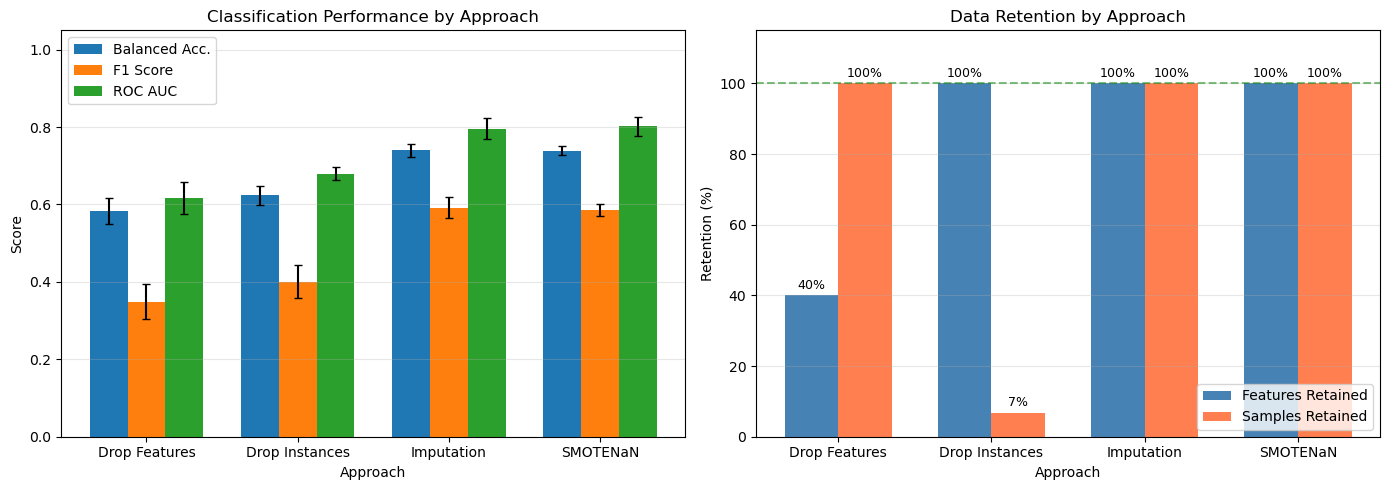

In [9]:
# =============================================================================
# Results Comparison - Metrics Table and Visualization
# =============================================================================

# Compile all results into a DataFrame
all_results = [
    results_drop_features,
    results_drop_instances,
    results_imputation,
    results_smotenan
]

# Create summary table
summary_data = []
for r in all_results:
    summary_data.append({
        'Approach': r['approach'],
        'Balanced Accuracy': f"{r['balanced_accuracy_mean']:.3f} +/- {r['balanced_accuracy_std']:.3f}",
        'F1 Score': f"{r['f1_mean']:.3f} +/- {r['f1_std']:.3f}",
        'Precision': f"{r['precision_mean']:.3f} +/- {r['precision_std']:.3f}",
        'Recall': f"{r['recall_mean']:.3f} +/- {r['recall_std']:.3f}",
        'ROC AUC': f"{r['roc_auc_mean']:.3f} +/- {r['roc_auc_std']:.3f}"
    })

summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Approach', inplace=True)

print("="*80)
print("RESULTS SUMMARY: Comparing NaN Handling Strategies")
print("="*80)
print()
print(summary_df.to_string())
print()

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Prepare data for plotting
approaches_short = ['Drop Features', 'Drop Instances', 'Imputation', 'SMOTENaN']

# Plot 1: Performance Metrics Comparison
ax1 = axes[0]
metrics_to_plot = ['balanced_accuracy', 'f1', 'roc_auc']
metric_labels = ['Balanced Acc.', 'F1 Score', 'ROC AUC']
x = np.arange(len(approaches_short))
width = 0.25

for i, (metric, label) in enumerate(zip(metrics_to_plot, metric_labels)):
    means = [r[f'{metric}_mean'] for r in all_results]
    stds = [r[f'{metric}_std'] for r in all_results]
    ax1.bar(x + i * width, means, width, yerr=stds, label=label, capsize=3)

ax1.set_xlabel('Approach')
ax1.set_ylabel('Score')
ax1.set_title('Classification Performance by Approach')
ax1.set_xticks(x + width)
ax1.set_xticklabels(approaches_short, ha='center')
ax1.legend(loc='upper left')
ax1.set_ylim(0, 1.05)
ax1.grid(axis='y', alpha=0.3)

# Plot 2: Data Retention Analysis
ax2 = axes[1]

# Calculate what each approach retains
original_features = X.shape[1]
original_samples = len(y)

# Features without NaN (for drop features approach)
features_complete = np.sum(~np.any(np.isnan(X), axis=0))
# Instances without NaN (for drop instances approach)
instances_complete = np.sum(~np.any(np.isnan(X), axis=1))

retention_data = {
    'Features (%)': [
        features_complete / original_features * 100,
        100,  # Drop instances keeps all features
        100,  # Imputation keeps all features
        100   # SMOTENaN keeps all features
    ],
    'Samples (%)': [
        100,  # Drop features keeps all samples
        instances_complete / original_samples * 100,
        100,  # Imputation keeps all samples
        100   # SMOTENaN keeps all samples
    ]
}

x2 = np.arange(len(approaches_short))
width2 = 0.35

bars1 = ax2.bar(x2 - width2/2, retention_data['Features (%)'], width2, 
                label='Features Retained', color='steelblue')
bars2 = ax2.bar(x2 + width2/2, retention_data['Samples (%)'], width2, 
                label='Samples Retained', color='coral')

ax2.set_xlabel('Approach')
ax2.set_ylabel('Retention (%)')
ax2.set_title('Data Retention by Approach')
ax2.set_xticks(x2)
ax2.set_xticklabels(approaches_short, ha='center')
ax2.legend(loc='lower right')
ax2.set_ylim(0, 115)
ax2.axhline(y=100, color='green', linestyle='--', alpha=0.5)
ax2.grid(axis='y', alpha=0.3)

# Add percentage labels on bars
for bar, pct in zip(bars1, retention_data['Features (%)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{pct:.0f}%', ha='center', va='bottom', fontsize=9)
for bar, pct in zip(bars2, retention_data['Samples (%)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{pct:.0f}%', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('overnan_synthetic_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


## Summary

This example demonstrates that SMOTENaN provides a practical solution for oversampling imbalanced datasets with missing values:

| Approach | Pros | Cons |
|----------|------|------|
| **Drop Features** | Simple, preserves samples | Loses potentially informative features |
| **Drop Instances** | Simple, preserves features | Loses samples, may worsen class imbalance |
| **Imputation** | Preserves data dimensions | Introduces artificial values, masks missing-mechanism |
| **SMOTENaN** | Preserves all original information | Requires NaN-aware classifier |

When working with classifiers that natively handle missing values (XGBoost, LightGBM, CatBoost), SMOTENaN offers a principled approach that respects both the class imbalance problem and the information encoded in missing values.

## References

1. Chawla, N.V., Bowyer, K.W., Hall, L.O., Kegelmeyer, W.P. (2002). SMOTE: Synthetic Minority Over-sampling Technique. *Journal of Artificial Intelligence Research*, 16, 321-357. [DOI: 10.1613/jair.953](https://doi.org/10.1613/jair.953)

2. Chen, T. and Guestrin, C. (2016). XGBoost: A Scalable Tree Boosting System. *Proceedings of the 22nd ACM SIGKDD International Conference on Knowledge Discovery and Data Mining*, 785-794. [DOI: 10.1145/2939672.2939785](https://doi.org/10.1145/2939672.2939785)